In [1]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import root_numpy as rtnp

version_id = 'v4'
SEED = 42

Using TensorFlow backend.


Welcome to JupyROOT 6.12/06


In [2]:
# get h5 datasets
data_path = "data/background/*_data.h5"
signal_path = "data/signal/*_data.h5"

data, data_tags, data_jets = utils.load_all_data(data_path, "background")
signal, signal_tags, signal_jets = utils.load_all_data(signal_path, "signal")

split = 0.2

train, test = data.train_test_split(split, SEED)
utils.compare_tags([train, test, data, signal])

data_raw = data.cdrop("*Flavor")
signal_raw = signal.cdrop("*Flavor")
train_raw = train.cdrop("*Flavor")
test_raw = test.cdrop("*Flavor")

norm_args = {"norm_type": "StandardScaler"}
train_norm, test_norm = train_raw.norm(**norm_args), train_raw.norm(test_raw, **norm_args)
data_norm, signal_norm = train_raw.norm(data_raw, **norm_args), train_raw.norm(signal_raw, **norm_args)

background tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%

bottom:
	3.2% (2664) train
	3.3% (677) test
	3.2% (3341) background
	78.8% (38995) signal
up:
	37.5% (30997) train
	37.9% (7844) test
	37.6% (38841) background
	3.8% (1866) signal
down:
	18.4% (15192) train
	18.4% (3807) test
	18.4% (18999) background
	2.5% (1220) signal
strange:
	24.6% (20367) train
	24.2% (5010) test
	24.5% (25377) background
	3.1% (1550) signal
charm:
	9.3% (7667) train
	9.2% (1910) test
	9.3% (9577) background
	6.8% (3344) signal
gluon:
	7.1% (5845) train
	6.9% (1436) test
	7.0% (7281) background
	5.1% (2541) signal


### Make autoencoder
Here we have some characterizing parameters for the VAE which can be messed with to try and acheive better results.

In [3]:
l1_amount = None          # l1 regularization amount
KL_loss_weight = 1.8    # according to olmo's paper
input_dim = 7              # num. HLF
interm_dim = 20            # num. interm nodes
neck_dim = 4             # num. latent variables
kernel_max_norm = None     # kernel max norm amount

name = "bn_{0}_{1}".format(neck_dim, version_id)
repo_head = utils.get_repo_info()['head']
model_path = repo_head + "/autoencode/data/training_runs/"

Loss functions and helpers

In [4]:
import keras.backend as K
import keras

def isrlu(args, min_value = 5e-3):
    """ranges from (0, +inf), with relu behavior at x > 0 and exponential decay at x < 0"""
    return 1. + min_value + K.tf.where(K.tf.greater(args, 0), args, K.tf.divide(args, K.sqrt(1+K.square(args))))

def sample_from_gauss(args):
    """reparam trick for VAE"""
    z_mean, z_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.shape(z_mean)[1]), mean=0., stddev=1.)
    return z_mean + z_sigma * epsilon

def make_zero(x):
    """lambda zero function, for forward pass of priors from x variable"""
    return 0.*x

def KL_loss(mu, sigma, mu_prior, sigma_prior):
    """KL loss from mu, sigma, and their priors"""
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

def reconstruction_probability(x, mu, sigma):
    """calculate gaussian -log likelihood across all variables and sum"""
    z_score = K.tf.divide(x - mu, sigma)
    single = - K.log(1./(sigma*np.sqrt(2.*np.pi)))/np.log(np.e) + 0.5*K.square(z_score)
    return K.sum(single, axis=-1)

class recon_prob_wrapper_layer(keras.layers.Layer):
    """Wrapper for recon. prob. function. 
    Outputs reconstruction probability of gaussians for vae
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(recon_prob_wrapper_layer, self).__init__(**kwargs)
    
    def call(self, inputs):
        x, mu, sigma = inputs
        return reconstruction_probability(x, mu, sigma)
    
class KL_loss_wrapper_layer(keras.layers.Layer):
    """Wrapper for KL_loss function. 
    Layer which outputs KL loss according the the function defined above
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(KL_loss_wrapper_layer, self).__init__(**kwargs)
    
    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss(mu, sigma, mu_prior, sigma_prior)
    
def Identity(y_train, vae_output):
    """identity loss, takes into account ONLY the VAE output (vae output should actually be the 
    calculated loss functions!)"""
    return K.mean(vae_output)

custom_objects = {
    "isrlu": isrlu,
    "sample_from_gauss": sample_from_gauss,
    "make_zero": make_zero,
    "KL_loss": KL_loss,
    "reconstruction_probability": reconstruction_probability,
    "recon_prob_wrapper_layer": recon_prob_wrapper_layer,
    "KL_loss_wrapper_layer": KL_loss_wrapper_layer,
    "Identity": Identity,
}

### Define layers
Define layers to setup layer architecture for later

In [5]:
import keras.backend as K
import keras
from keras.constraints import max_norm

# define layers
input_layer = keras.layers.Input(shape=(input_dim,), name="input")

intermediate_layer_enc1 = keras.layers.Dense(interm_dim, name="hidden_enc1")
intermediate_layer_enc2 = keras.layers.Dense(interm_dim, activation='relu', kernel_constraint=max_norm(kernel_max_norm), name='hidden_enc2')

z_mu_layer = keras.layers.Dense(neck_dim, name='z_mu')
z_sigma_pre_layer = keras.layers.Dense(neck_dim, name="z_sigma_pre")
z_sigma_layer = keras.layers.Lambda(isrlu, name="z_sigma")

z_latent_layer = keras.layers.Lambda(sample_from_gauss, name="latent_sampling")
z_input_layer = keras.layers.Input(shape=(neck_dim,), name="z_input_layer")

intermediate_layer_dec1 = keras.layers.Dense(interm_dim, name="hidden_dec1", kernel_constraint=max_norm(kernel_max_norm))
intermediate_layer_dec2 = keras.layers.Dense(interm_dim, name="hidden_dec2")

output_sigma_pre_layer = keras.layers.Dense(input_dim, name="output_sigma_pre", activation="linear")
output_sigma_layer = keras.layers.Lambda(isrlu, name="output_sigma")
output_mu_layer = keras.layers.Dense(input_dim, name="output_mu", activation="linear")

# prior layers for KL divergence
fixed_input_layer = keras.layers.Lambda(make_zero, name="fixed_input")
prior_layer = keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer='ones', trainable=False, name='prior')
prior_mu_layer = keras.layers.Dense(neck_dim, kernel_initializer='zeros', bias_initializer='zeros', trainable=True, name='prior_mu')
prior_sigma_pre_layer = keras.layers.Dense(neck_dim, kernel_initializer='zeros', bias_initializer='ones', trainable=True, name='prior_sigma_pre')
prior_sigma_layer = keras.layers.Lambda(isrlu, name='prior_sigma')

In [6]:
## INPUT to encoder
aux = intermediate_layer_enc1(input_layer)   # first intermediate layer
aux = intermediate_layer_enc2(aux)

z_mu = z_mu_layer(aux)                    # z mu layer
z_sigma = z_sigma_layer(z_sigma_pre_layer(aux)) # z sigma layer (with correction)
z_latent = z_latent_layer([z_mu, z_sigma])      # z latent layer (draw from latent distribution, zmu/zsigma)

## INPUT to decoder
aux = intermediate_layer_dec1(z_latent) # z_input_layer if you want a decoder
aux = intermediate_layer_dec2(aux)
out_mu = output_mu_layer(aux)
out_sigma = output_sigma_layer(output_sigma_pre_layer(aux))
## OUTPUT to decoder

# reparameterization trick!
fixed_input = fixed_input_layer(input_layer)        # fixed input layer (no training)
prior = prior_layer(fixed_input)                    # prior layer (one node, all constant)
prior_mu = prior_mu_layer(prior)                    # mu layer (all ones, trainable)
prior_sigma = prior_sigma_layer(prior_sigma_pre_layer(prior)) # sigma layer (all geq zero, trainable)


# # make encoder/decoder models
# encoder = keras.models.Model(inputs=input_layer, outputs=z_latent, name="encoder")
# decoder = keras.models.Model(inputs=z_input_layer, outputs=[out_mu, out_sigma], name="decoder")

# reconstruction probability: create from input layer, as well as outputs of decoder (mu/sigma out)
reco_prob_out = recon_prob_wrapper_layer(name="reconstructed_probability")([input_layer, out_mu, out_sigma])
# KL loss: create from zed mu/sigma, as well as prior variables
KL_loss_out = KL_loss_wrapper_layer(name="KL_loss_layer")([z_mu, z_sigma, prior_mu, prior_sigma])

# autoencoder made from x-input to loss outputs
vae = keras.models.Model(inputs=input_layer, outputs=[KL_loss_out, reco_prob_out])

vae.compile(optimizer="adam", loss=[Identity, Identity], loss_weights=[KL_loss_weight, 1.])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 7)            0                                            
__________________________________________________________________________________________________
hidden_enc1 (Dense)             (None, 20)           160         input[0][0]                      
__________________________________________________________________________________________________
hidden_enc2 (Dense)             (None, 20)           420         hidden_enc1[0][0]                
__________________________________________________________________________________________________
z_sigma_pre (Dense)             (None, 4)            84          hidden_enc2[0][0]                
__________________________________________________________________________________________________
z_mu (Dens

In [7]:
instance = trainer.trainer(os.path.join(model_path, name))

h5_elt 'metric_names' :: creating group 'data' in file 'bn_4_v4.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'bn_4_v4.h5'
h5_elt 'training' :: creating group 'params' in file 'bn_4_v4.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'bn_4_v4.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'bn_4_v4.h5'


In [18]:
# vae = instance.load_model(custom_objects=custom_objects)

In [9]:
train = True
if train:
    vae = instance.train(
        x_train=train_norm.data,
        x_test=test_norm.data,
        y_train=[np.empty((train_norm.shape[0], neck_dim)), np.empty_like(train_norm.data)],
        y_test=[np.empty((test_norm.shape[0], neck_dim)), np.empty_like(test_norm.data)],
        optimizer="adam",
        loss=[Identity, Identity],
        loss_weights=[0., 1.0],
        epochs=20,
        model=vae,
        use_callbacks=True,
        learning_rate=0.0005,
        custom_objects=custom_objects,
        batch_size=500
    )
    vae = instance.train(
        x_train=train_norm.data,
        x_test=test_norm.data,
        y_train=[np.empty((train_norm.shape[0], neck_dim)), np.empty_like(train_norm.data)],
        y_test=[np.empty((test_norm.shape[0], neck_dim)), np.empty_like(test_norm.data)],
        optimizer="adam",
        loss=[Identity, Identity],
        loss_weights=[1.8, 1.0],
        epochs=100,
        model=vae,
        use_callbacks=True,
        learning_rate=0.0005,
        custom_objects=custom_objects,
        batch_size=500
    )

Train on 82732 samples, validate on 20684 samples
Epoch 1/20
82732/82732 [==============================] - 2s 22us/step - loss: 81.6447 - KL_loss_layer_loss: 8.0191 - reconstructed_probability_loss: 81.6447 - val_loss: 18.0617 - val_KL_loss_layer_loss: 6.9919 - val_reconstructed_probability_loss: 18.0617
Epoch 2/20
82732/82732 [==============================] - 1s 13us/step - loss: 15.7176 - KL_loss_layer_loss: 6.6358 - reconstructed_probability_loss: 15.7176 - val_loss: 12.5363 - val_KL_loss_layer_loss: 6.3316 - val_reconstructed_probability_loss: 12.5363
Epoch 3/20
82732/82732 [==============================] - 1s 13us/step - loss: 12.1058 - KL_loss_layer_loss: 6.1762 - reconstructed_probability_loss: 12.1058 - val_loss: 11.6217 - val_KL_loss_layer_loss: 6.0215 - val_reconstructed_probability_loss: 11.6217
Epoch 4/20
82732/82732 [==============================] - 1s 12us/step - loss: 11.2606 - KL_loss_layer_loss: 5.9207 - reconstructed_probability_loss: 11.2606 - val_loss: 10.8055 -

2019-07-18 16:12:18.812724: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F


In [20]:
vae = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=[np.empty((train_norm.shape[0], neck_dim)), np.empty_like(train_norm.data)],
    y_test=[np.empty((test_norm.shape[0], neck_dim)), np.empty_like(test_norm.data)],
    optimizer="adam",
    loss=[Identity, Identity],
    loss_weights=[1.65, 1.0],
    epochs=100,
    model=vae,
    use_callbacks=True,
    learning_rate=0.0005,
    custom_objects=custom_objects,
    batch_size=500
)

train_shell :: ERROR: IGNORING PASSED PARAMETER 'model'
train_shell :: using saved model
Train on 82732 samples, validate on 20684 samples
Epoch 121/220
82732/82732 [==============================] - 2s 19us/step - loss: 3.9406 - KL_loss_layer_loss: -1.0558 - reconstructed_probability_loss: 5.6827 - val_loss: -1.2362 - val_KL_loss_layer_loss: -1.0555 - val_reconstructed_probability_loss: 0.5054
Epoch 122/220
82732/82732 [==============================] - 1s 12us/step - loss: -1.2422 - KL_loss_layer_loss: -1.0404 - reconstructed_probability_loss: 0.4744 - val_loss: -1.2846 - val_KL_loss_layer_loss: -1.0221 - val_reconstructed_probability_loss: 0.4019
Epoch 123/220
82732/82732 [==============================] - 1s 12us/step - loss: -1.2484 - KL_loss_layer_loss: -1.0091 - reconstructed_probability_loss: 0.4166 - val_loss: -1.0865 - val_KL_loss_layer_loss: -1.0064 - val_reconstructed_probability_loss: 0.5741
Epoch 124/220
82732/82732 [==============================] - 1s 12us/step - loss: 

### Training progress
Obviously, KL loss was not weighted properly in this attempt. We won't mind that now, though. 

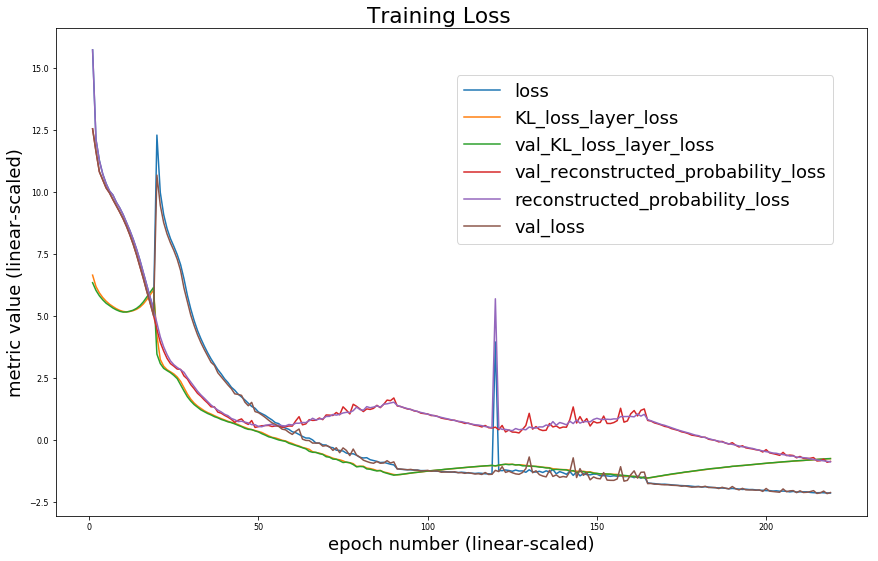

In [23]:
instance.plot_metrics(fnmatch_criteria="*loss*", figloc=(.52,.565), figsize=(12,8), figname='Training Loss')

In [24]:
z_mu, z_sigma = vae.get_layer("z_mu").output, vae.get_layer("z_sigma").output
input_layer = vae.get_layer("input").output

z_out = vae.get_layer("latent_sampling").output
out_mu, out_sigma = vae.get_layer("output_mu").output, vae.get_layer("output_sigma").output

encoder = keras.models.Model(inputs=input_layer, outputs=[z_mu, z_sigma])
autoencoder = keras.models.Model(inputs=input_layer, outputs=[out_mu, out_sigma])
zencoder = keras.models.Model(inputs=input_layer, outputs=z_out)

# aux = encoder.predict(np.zeros((1,input_dim)))
# mu_prior = aux[0][0]
# sigma_prior = aux[1][0]

# mu_prior, sigma_prior

inputs_out = [data_norm, signal_norm]
outputs_out = [autoencoder.predict(data_norm.data), autoencoder.predict(signal_norm.data)]

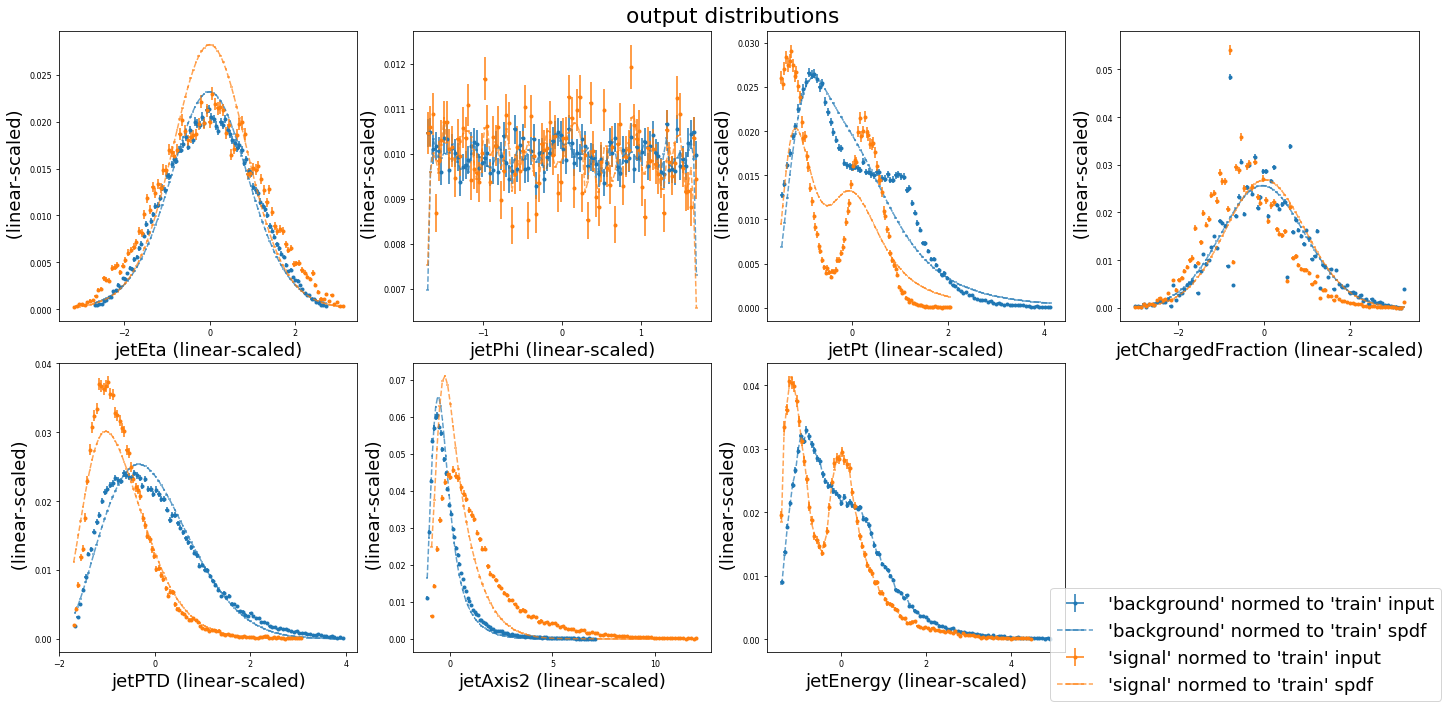

In [25]:
utils.plot_spdfs(inputs_out, outputs_out, figname="output distributions")


In [26]:
signal_jets_norm, data_jets_norm = [
    [train_raw.norm(j.cfilter(signal_norm.headers), **norm_args) for j in jet_table] for jet_table in [signal_jets, data_jets]
]

nodenames = ['node {}'.format(i) for i in range(neck_dim)]

data_reps, signal_reps = (
    utils.data_table(zencoder.predict(data_norm.data), headers=nodenames, name="background_reps"),
    utils.data_table(zencoder.predict(signal_norm.data), headers=nodenames, name="signal_reps")
)

data_jet_reps, signal_jet_reps = (
    [utils.data_table(zencoder.predict(d.data), headers=nodenames, name="jet {} background reps".format(i)) for i,d in enumerate(data_jets_norm)],
    [utils.data_table(zencoder.predict(d.data), headers=nodenames, name="jet {} signal reps".format(i)) for i,d in enumerate(signal_jets_norm)],
)

data_table :: plotting distrubution(s) for table(s) ['jet 0 signal reps', 'jet 1 signal reps', 'jet 0 background reps', 'jet 1 background reps']


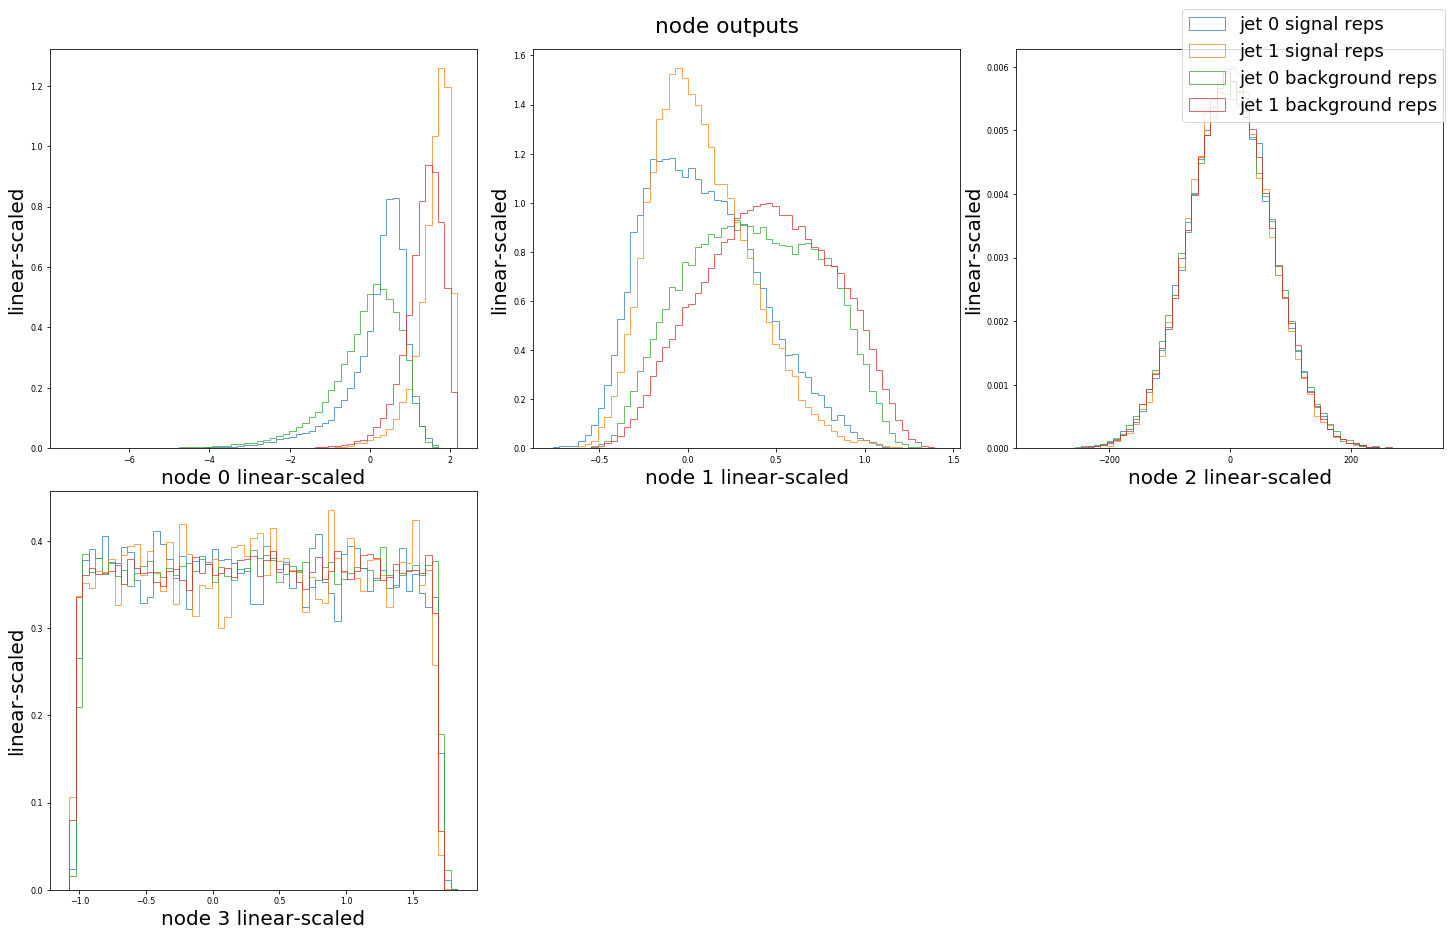

In [27]:
# node_outputs[0].plot(node_outputs[1], normed=1, figname='node outputs', figloc='upper right', figsize=15, fontsize=20, cols=2)
signal_jet_reps[0].plot(
    signal_jet_reps[1:] + data_jet_reps, 
    normed=1, figname='node outputs', figloc='upper right', 
    figsize=20, fontsize=20, cols=3, bins=60)


In [28]:
err_data = utils.data_table(vae.predict(data_norm.data)[1], headers=['loss'], name='combined data error')
err_signal = utils.data_table(vae.predict(signal_norm.data)[1], headers=['loss'], name='combined signal error')
err_data_jets = [
    utils.data_table(
        vae.predict(d.data)[1],
        headers=['loss'],
        name='jet {} background error'.format(i + 1)
    ) for i,d in enumerate(data_jets_norm)
]

err_signal_jets = [
    utils.data_table(
        vae.predict(d.data)[1],
        headers=['loss'],
        name='jet {} signal error'.format(i + 1)
    ) for i,d in enumerate(signal_jets_norm)
]

data_table :: plotting distrubution(s) for table(s) ['jet 1 signal error', 'jet 2 signal error', 'jet 1 background error', 'jet 2 background error']


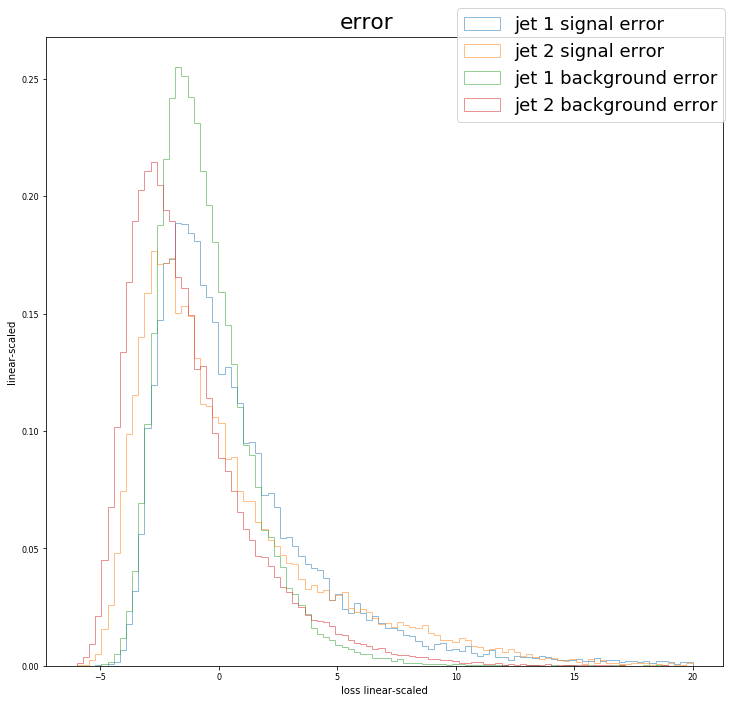

In [29]:
err_signal_jets[0].plot(
    err_signal_jets[1:] + err_data_jets, bins=100, normed=1, yscale='linear',
    figsize=(10,10), alpha=1.5, rng=(-6, 20), figloc="upper right",
    figname="error"
)

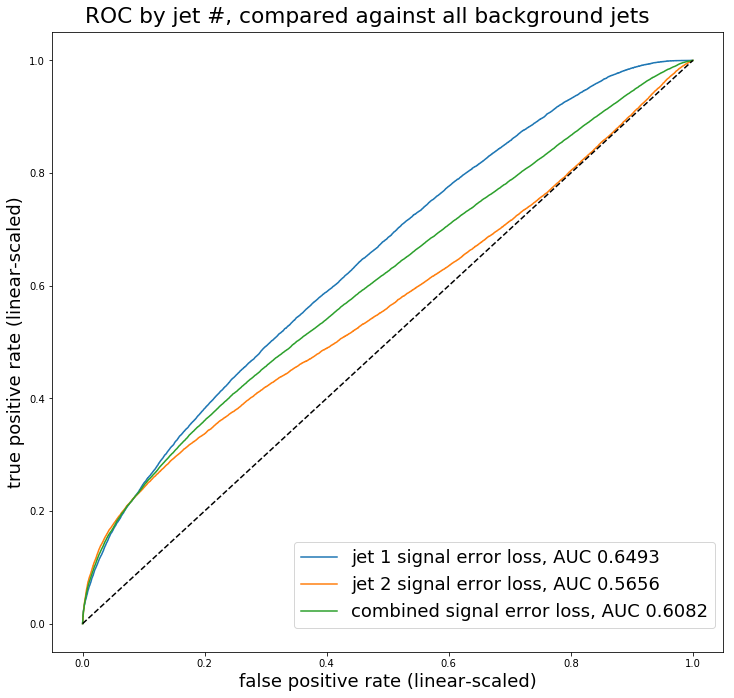

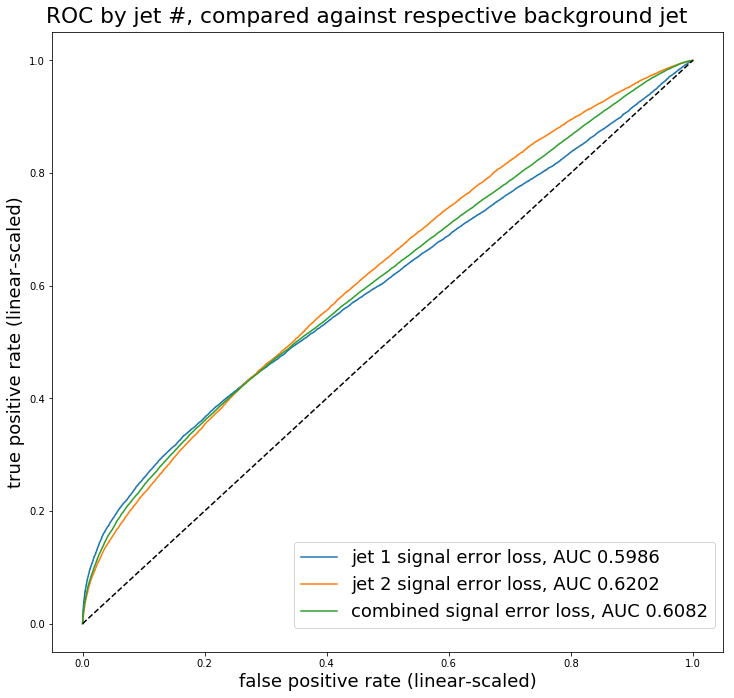

In [31]:
utils.roc_auc_plot([err_data], err_signal_jets + [err_signal], ticksize=10, yscale='linear', figsize=10, figloc=(.4, .10), figname="ROC by jet #, compared against all background jets")
utils.roc_auc_plot(err_data_jets + [err_data], err_signal_jets + [err_signal], ticksize=10, yscale='linear', figsize=10, figloc=(.4, .10), figname="ROC by jet #, compared against respective background jet")

In [ ]:

# def plot_vae_necknodes(encoder, x_ins, bins=50, *args, **kwargs):
    
#     input_dim = encoder.layers[0].get_input_shape_at(0)[1]
#     aux = encoder.predict(np.zeros((1, input_dim)))
#     mu_prior = aux[0][0]
#     sigma_prior = aux[1][0]
    
#     to_calculate = [encoder.predict(d.data) for d in x_ins] 
    
#     assert len(mu_prior) == len(sigma_prior)
#     neck_dim = len(mu_prior)
    
#     fig, ax_on, ax_off, plt_end, colors = get_plot_params(neck_dim, *args, **kwargs)
    
#     for i in range(neck_dim):
#         ax = ax_on(i)
#         lower = mu_prior[i] - 6*sigma_prior[i]
#         upper = mu_prior[i] + 6*sigma_prior[i]

#         width = (upper - lower) / bins
#         z = np.arange(lower, upper, width)
        
#         for j,calc in enumerate(to_calculate):
            
#             mus, sigmas = calc
#             content = sum_of_gaussians(z, mus[i], sigmas[i])*width
#             ax.errorbar(z + width/2., content, xerr=width/2, c=colors[j], label=x_ins[j].name)
        
#         ax_off("node {}".format(i))
#     plt_end()
        
# plot_vae_necknodes(encoder, inputs)